In [1]:
DATASET_DIR = "./"

In [4]:
import numpy as np
#load  numpy dataset
xs = np.load(DATASET_DIR + "xs.npy")
ys = np.load(DATASET_DIR + "ys.npy")
ys_encoded = np.load(DATASET_DIR + "ys_encoded.npy")

print("xs shape:", xs.shape)
print("ys shape:", ys.shape)
print("ys_encoded shape:", ys_encoded.shape)

xs shape: (6400, 256, 256, 3)
ys shape: (6400,)
ys_encoded shape: (6400,)


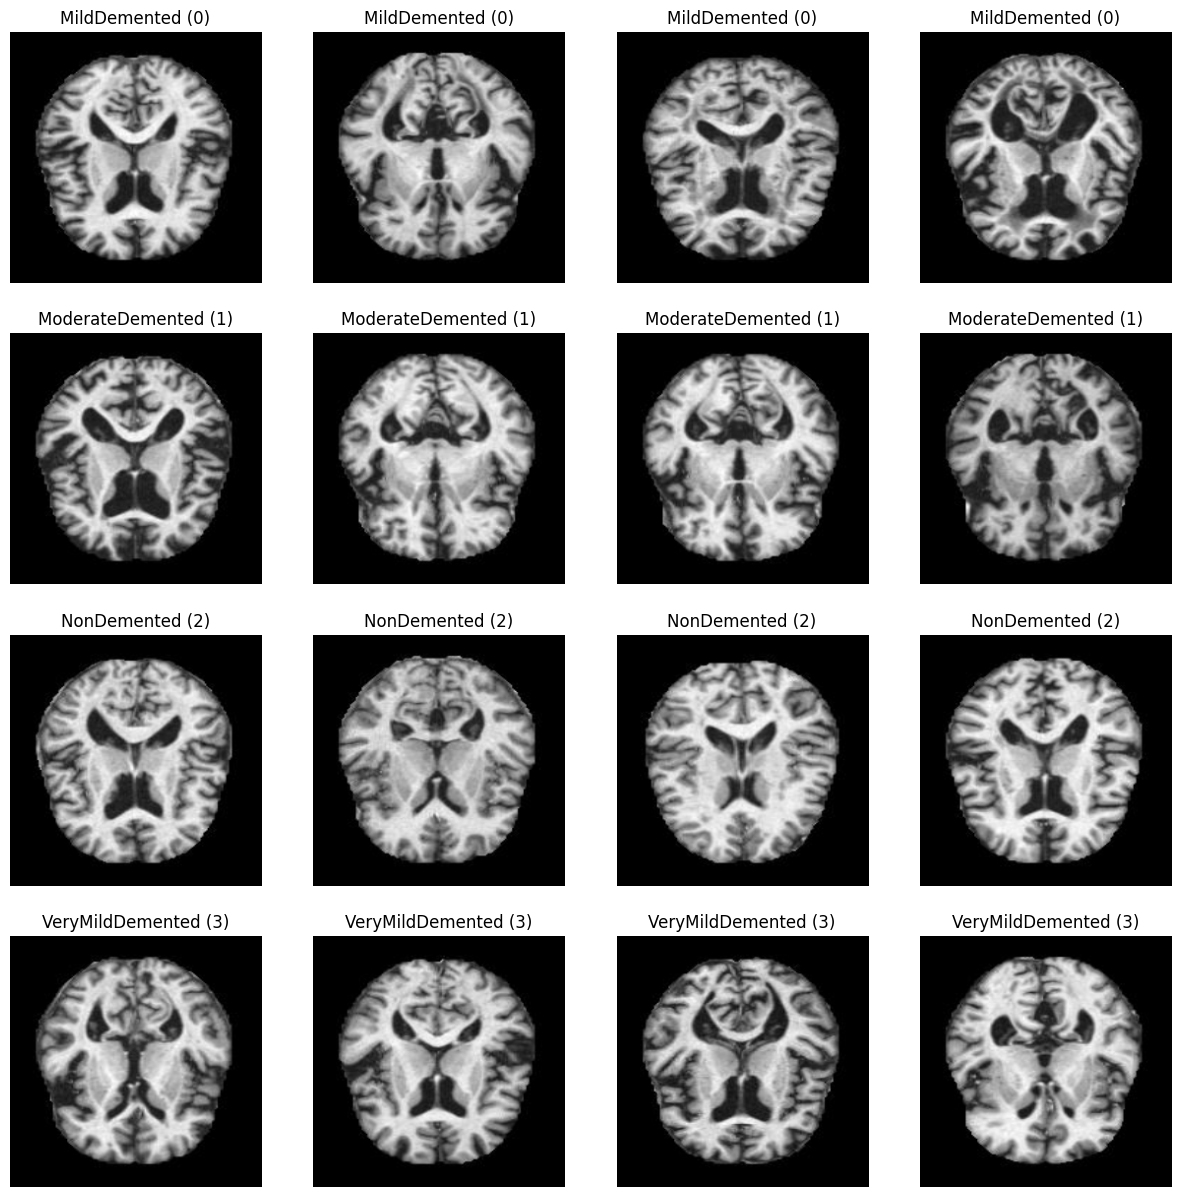

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

#show images each class
unique_labels = np.unique(ys)
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, label in enumerate(unique_labels):
    class_indices = np.where(ys == label)[0]
    for j, index in enumerate(class_indices[:4]):
        if index < len(xs):
            axes[i, j].imshow(cv2.cvtColor(xs[index], cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(f"{ys[index]} ({ys_encoded[index]})")
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')


    for j in range(len(class_indices), 4):
        axes[i,j].axis('off')


#plt.tight_layout()
plt.show()

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image, output_size=(256, 256)):
    resized_image = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)

    min_val = np.min(resized_image)
    max_val = np.max(resized_image)

    if max_val - min_val == 0:
        norm_image = np.zeros_like(resized_image, dtype=np.float32)
    else:
        norm_image = (resized_image - min_val) / (max_val - min_val)

    return norm_image

def apply_gaussian_smoothing(image, kernel_size=5, sigma=1.0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def apply_bilateral_filter(image, diameter=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

def sobel_edge_detection(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y

    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 1, cv2.NORM_MINMAX)
    return gradient_magnitude

def full_preprocessing_pipeline(image):
    resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
    min_val = np.min(resized_image)
    max_val = np.max(resized_image)
    if max_val - min_val == 0:
        normalized_image = np.zeros_like(resized_image, dtype=np.float32)
    else:
        normalized_image = (resized_image - min_val) / (max_val - min_val)


    smoothed = apply_gaussian_smoothing((normalized_image * 255).astype(np.uint8))
    median_filtered = apply_median_filter(smoothed)
    bilateral_filtered = apply_bilateral_filter(median_filtered)


    edges = sobel_edge_detection(bilateral_filtered)

    return normalized_image, bilateral_filtered, edges

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

# Preprocess all images
preprocessed_xs = []
for x in tqdm(xs):
    normalized_image, bilateral_filtered, edges = full_preprocessing_pipeline(x)
    preprocessed_xs.append(edges) # or bilateral_filtered or edges

preprocessed_xs = np.array(preprocessed_xs)
print("Preprocessed xs shape:", preprocessed_xs.shape)

100%|██████████| 6400/6400 [01:10<00:00, 90.75it/s]


Preprocessed xs shape: (6400, 256, 256, 3)


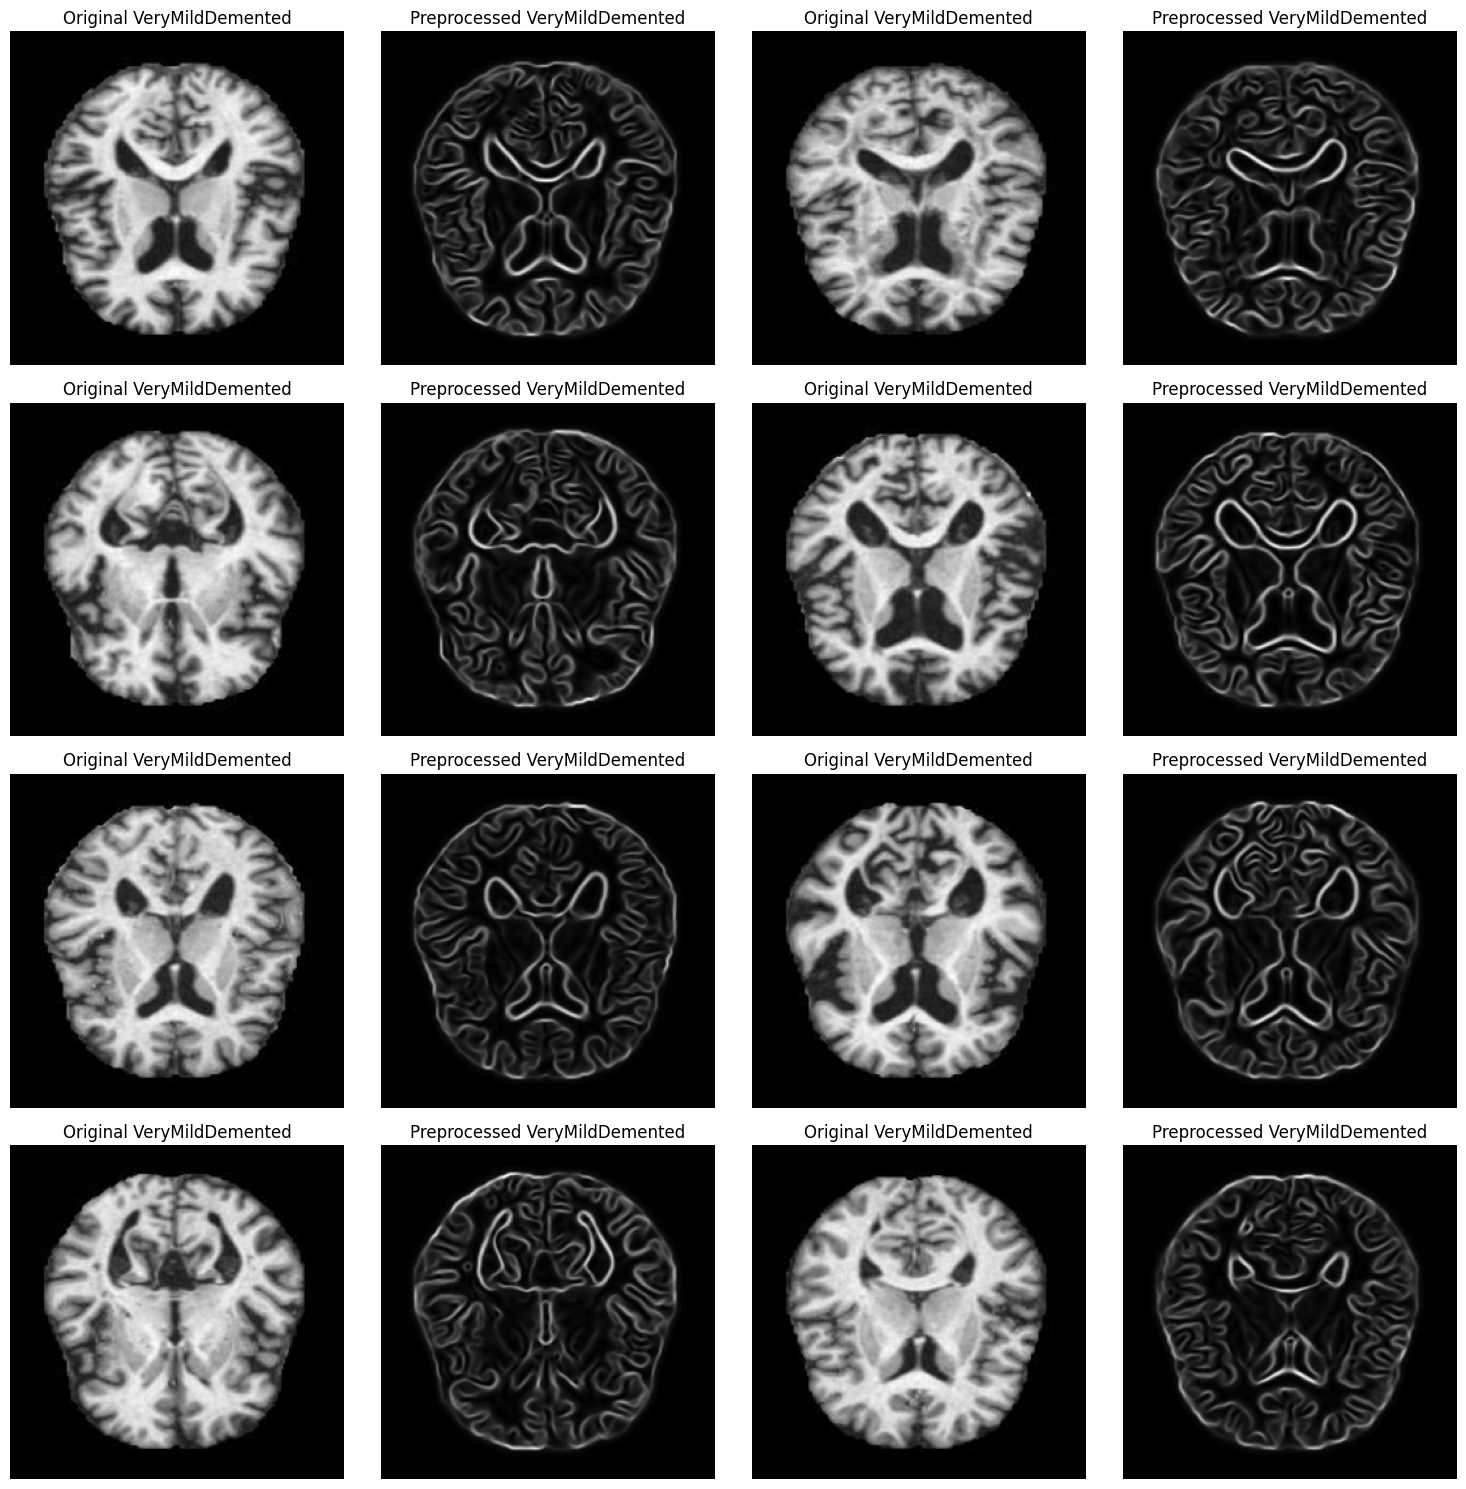

In [18]:


import numpy as np
import matplotlib.pyplot as plt

num_images_to_compare = 16 # 4x4 grid
selected_indices = np.random.choice(len(xs), size=num_images_to_compare, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i in range(4):
    for j in range(0, 4, 2):
        index = i * 2 + j
        class_indices = np.where(ys_encoded == i)[0]
        original_image = xs[class_indices[index]]
        preprocessed_image = preprocessed_xs[class_indices[index]]

        axes[i, j].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        axes[i, j].set_title('Original ' + ys[index])
        axes[i, j].axis('off')

        axes[i, j+1].imshow(cv2.cvtColor(preprocessed_image.astype(np.float32), cv2.COLOR_BGR2RGB))
        axes[i, j+1].set_title('Preprocessed '+ ys[index])
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# save images
np.save(DATASET_DIR + "preprocessed_xs.npy", preprocessed_xs)
